# Python Questions
Question 5 - 6

In [1]:
#!/usr/bin/env python
import pandas as pd

vanorder_path = 'data/vanorder.csv'
vaninterest_path = 'data/vaninterest.csv'

vanorder = pd.read_csv(vanorder_path, parse_dates=['order_datetime', 'txCreate'])
vaninterest = pd.read_csv(vaninterest_path, parse_dates=['txCreate'])

In [2]:
vanorder.dtypes

idvanOrder                      int64
order_status                    int64
order_subset                   object
requestor_client_id             int64
servicer_auth                 float64
total_price                     int64
order_datetime         datetime64[ns]
txCreate               datetime64[ns]
dtype: object

# Question 5
### What is the order fulfillment rate, i.e. percentage of orders that was completed, based on order time?

See the rate of [order_status = 2] for orders completed.

In [3]:
vanorder.groupby(vanorder.order_datetime.dt.hour)['order_status'].value_counts(normalize=True)

order_datetime  order_status
4               2               1.000000
7               2               1.000000
8               2               1.000000
9               2               0.800000
                3               0.200000
10              2               0.954545
                3               0.045455
11              2               0.965517
                3               0.034483
12              2               0.965517
                5               0.034483
13              2               1.000000
14              2               1.000000
15              2               0.900000
                3               0.100000
16              2               0.857143
                3               0.142857
17              2               0.958333
                3               0.041667
18              2               1.000000
19              2               0.928571
                3               0.071429
20              2               0.909091
                3           

# Question 6
only considering order subset A >>> vaninterest.order_subset_assigned = 'A'

## Match time :
The taken time from user placing the order (txCreate in vanorder), to the driver accepting the order (txCreate in vaninterst)

= vaninterst.txCreate - vanorder.txCreate

In [4]:
A = vaninterest[['idvanOrder', 'order_subset_assigned', 'servicer_auth', 'txCreate']].copy()
A = A[A.order_subset_assigned == 'A']
A.rename(columns={'txCreate' : 'accepted_time'}, inplace=True)
A = pd.merge(A,vanorder[['idvanOrder', 'servicer_auth', 'txCreate', 'order_datetime']], on=['idvanOrder', 'servicer_auth'])
A.rename(columns={'txCreate' : 'placed_time'}, inplace=True)
A = A.drop(columns=['order_subset_assigned','servicer_auth'])
A['match_time']= abs((A['accepted_time'] - A['placed_time']))
A = A[['idvanOrder', 'placed_time', 'accepted_time', 'order_datetime', 'match_time']]
A.head(10)

,idvanOrder,placed_time,accepted_time,order_datetime,match_time
0,1,2017-04-18 00:46:44,2017-04-18 05:06:00,2017-04-18 15:30:00,04:19:16
1,2,2017-04-18 06:42:40,2017-04-18 06:43:00,2017-04-18 07:10:00,00:00:20
2,3,2017-04-18 06:44:09,2017-04-18 06:59:00,2017-04-18 07:10:00,00:14:51
3,5,2017-04-18 07:27:42,2017-04-18 07:32:00,2017-04-18 09:00:00,00:04:18
4,6,2017-04-18 07:43:05,2017-04-18 07:45:00,2017-04-18 08:30:00,00:01:55
5,7,2017-04-18 08:11:40,2017-04-18 08:12:00,2017-04-18 08:40:00,00:00:20
6,8,2017-04-18 08:29:50,2017-04-18 08:30:00,2017-04-18 09:20:00,00:00:10
7,9,2017-04-18 08:43:59,2017-04-18 08:45:00,2017-04-18 09:30:00,00:01:01
8,12,2017-04-18 09:31:06,2017-04-18 09:31:00,2017-04-18 10:20:00,00:00:06
9,13,2017-04-18 09:32:05,2017-04-18 09:33:00,2017-04-18 10:20:00,00:00:55


For some data, order placed time by the clients is later than the order accepted time by drivers. It is not reasonable to happen. It may indicate some errors caused during data collection.

### (a) What is the average match time, by immediate/advanced orders? Immediate orders are defined as orders with order time within 60 minutes(inclusive) of placed time.

In [5]:
A['placed_hour'] = A.placed_time.dt.hour
imm = A.loc[(A['order_datetime'] - A['placed_time'])<=pd.Timedelta('60 minutes')]
imm.mean()

idvanOrder                    145.596
match_time     0 days 00:00:55.828947
placed_hour                    13.864
dtype: object

In [6]:
adv = A.loc[(A['order_datetime'] - A['placed_time'])>pd.Timedelta('60 minutes')]
adv.mean()

idvanOrder                      161.5
match_time     0 days 00:12:45.571428
placed_hour                   14.6429
dtype: object

Match time mean of immediate orders: 55 seconds

Match time mean of advanced orders: 12 minutes 45 seconds

### (b) What is the median match time, again by immediate/advanced?

In [7]:
imm.median()

idvanOrder               140.5
match_time     0 days 00:00:23
placed_hour               13.5
dtype: object

In [8]:
adv.median()

idvanOrder               172.5
match_time     0 days 00:00:38
placed_hour                 15
dtype: object

Match time median of immediate orders: 23 seconds

Match time median of advanced orders: 38 seconds

In [9]:
imm.std()

idvanOrder                    82.7548
match_time     0 days 00:02:19.282496
placed_hour                   3.15446
dtype: object

In [10]:
adv.std()

idvanOrder                    102.036
match_time     0 days 00:40:51.889914
placed_hour                   4.76686
dtype: object

### (c) Which of the above one do you think provides a better representation the data, i.e. a better metric for tracking our performance in matching?

Medians of both immediate and advanced data are smaller than means, and it seems mean is a better metric for tracking performance in matching. The reason is shown below.

# Codes for Q.7,8

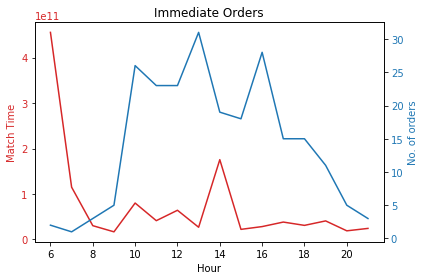

In [16]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Hour')
ax1.set_ylabel('Match Time',color=color)
ax1.plot(imm.groupby('placed_hour')['match_time'].mean(numeric_only=False),color=color)
ax1.tick_params(axis='y',labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('No. of orders',color=color)
ax2.plot(imm['placed_hour'].value_counts().sort_index(),color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Immediate Orders')
fig1.tight_layout()
plt.show()

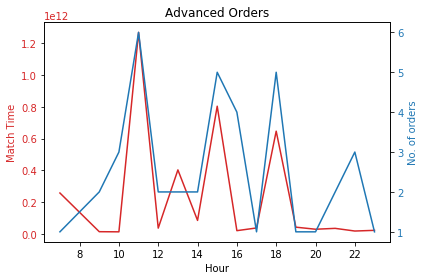

In [12]:
adv = adv.drop([0])
fig2, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Hour')
ax1.set_ylabel('Match Time',color=color)
ax1.plot(adv.groupby('placed_hour')['match_time'].mean(numeric_only=False),color=color)
ax1.tick_params(axis='y',labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('No. of orders',color=color)
ax2.plot(adv['placed_hour'].value_counts().sort_index(),color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Advanced Orders')
fig2.tight_layout()
plt.show()

These two graphs show that for immediate orders, number of orders are significantly higher for shorter match time while match time for advanced orders at time with higher number of orders is greater. Therefore, it seems the means are better estimations.
These graphs also can be a great suggestion for the operation team so that they can find the way to reduce the match time at where many advanced orders are made.

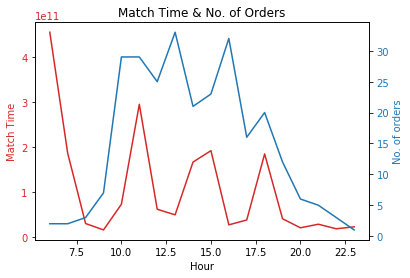

In [13]:
A = A.drop([0])
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Hour')
ax1.set_ylabel('Match Time',color=color)
ax1.plot(A.groupby('placed_hour')['match_time'].mean(numeric_only=False),color=color)
ax1.tick_params(axis='y',labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('No. of orders',color=color)
ax2.plot(A['placed_hour'].value_counts().sort_index(),color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Match Time & No. of Orders')
fig2.tight_layout()
plt.show()

In [14]:
B = vanorder[vanorder['order_status']==2]
B = B['requestor_client_id'].value_counts().reset_index()
B.columns = ['money','order_count']
B.head()

,money,order_count
0,48,8
1,125,5
2,14,5
3,199,4
4,160,4


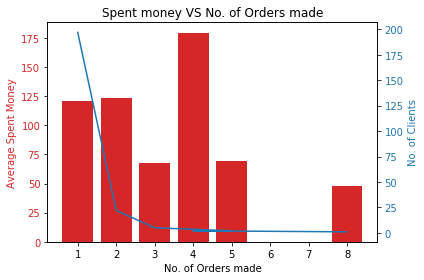

In [15]:
C = B.groupby('order_count').mean()['money'].reset_index()

spent, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('No. of Orders made')
ax1.set_ylabel('Average Spent Money',color=color)
ax1.bar(C['order_count'],C.groupby('order_count').mean()['money'], color=color)
ax1.tick_params(axis='y',labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('No. of Clients',color=color)
ax2.plot(B['order_count'].value_counts())
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Spent money VS No. of Orders made')
spent.tight_layout()
plt.show()